# load library

In [11]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 5.9 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=9b8c62e38b6a367afe2be0db537242be4dea148406cb3bbcd6255ef4ef144883
  Stored in directory: /root/.cache/pip/wheels/b7/d8/5b/d765b9e8b0c00c0a902ef97f86fe44b9f82ead731c3fb732c9
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408217 sha256=399c929d7384a943ed36c3fa97aedb0c0aba7663d2aad036da8ae4b2f93d61b2
  Stored in directory: /root/.cache/pip/wheels/fb/b1/fc/b05c2c1930a412f01bd07dacaeb5fd8cc4bcccf71c835b0281
Successfully built torchnet visdom


In [43]:
#torch

from torch.nn import Parameter
import torch
import torch.optim
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

import torch.utils.data as Data
import torch.backends.cudnn as cudnn


#torchnet???
import torchnet as tnt


#numpy
import numpy as np

#pandas
import pandas as pd

#utility

import math
from urllib.request import urlretrieve

from PIL import Image
from tqdm import tqdm
import random

import json
import os
import pickle
import shutil
import time


# define utility class & function

In [13]:
class Warp(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = int(size)
        self.interpolation = interpolation

    def __call__(self, img):
        return img.resize((self.size, self.size), self.interpolation)

    def __str__(self):
        return self.__class__.__name__ + ' (size={size}, interpolation={interpolation})'.format(size=self.size,
                                                                                                interpolation=self.interpolation)
class MultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, 875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img):
        im_size = img.size
        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h))
        ret_img_group = crop_img_group.resize((self.input_size[0], self.input_size[1]), self.interpolation)
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


    def __str__(self):
        return self.__class__.__name__


def download_url(url, destination=None, progress_bar=True):
    """Download a URL to a local file.

    Parameters
    ----------
    url : str
        The URL to download.
    destination : str, None
        The destination of the file. If None is given the file is saved to a temporary directory.
    progress_bar : bool
        Whether to show a command-line progress bar while downloading.

    Returns
    -------
    filename : str
        The location of the downloaded file.

    Notes
    -----
    Progress bar use/example adapted from tqdm documentation: https://github.com/tqdm/tqdm
    """

    def my_hook(t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            if b > 0:
                t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

    if progress_bar:
        with tqdm(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            filename, _ = urlretrieve(url, filename=destination, reporthook=my_hook(t))
    else:
        filename, _ = urlretrieve(url, filename=destination)


class AveragePrecisionMeter(object):
    """
    The APMeter measures the average precision per class.
    The APMeter is designed to operate on `NxK` Tensors `output` and
    `target`, and optionally a `Nx1` Tensor weight where (1) the `output`
    contains model output scores for `N` examples and `K` classes that ought to
    be higher when the model is more convinced that the example should be
    positively labeled, and smaller when the model believes the example should
    be negatively labeled (for instance, the output of a sigmoid function); (2)
    the `target` contains only values 0 (for negative examples) and 1
    (for positive examples); and (3) the `weight` ( > 0) represents weight for
    each sample.
    """

    def __init__(self, difficult_examples=False):
        super(AveragePrecisionMeter, self).__init__()
        self.reset()
        self.difficult_examples = difficult_examples

    def reset(self):
        """Resets the meter with empty member variables"""
        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):
        """
        Args:
            output (Tensor): NxK tensor that for each of the N examples
                indicates the probability of the example belonging to each of
                the K classes, according to the model. The probabilities should
                sum to one over all classes
            target (Tensor): binary NxK tensort that encodes which of the K
                classes are associated with the N-th input
                    (eg: a row [0, 1, 0, 1] indicates that the example is
                         associated with classes 2 and 4)
            weight (optional, Tensor): Nx1 tensor representing the weight for
                each example (each weight > 0)
        """
        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'
        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        # make sure storage is of sufficient size
        if self.scores.storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.storage().size() * 1.5)
            self.scores.storage().resize_(int(new_size + output.numel()))
            self.targets.storage().resize_(int(new_size + output.numel()))

        # store scores and targets
        offset = self.scores.size(0) if self.scores.dim() > 0 else 0
        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):
        """Returns the model's average precision for each class
        Return:
            ap (FloatTensor): 1xK tensor, with avg precision for each class k
        """

        if self.scores.numel() == 0:
            return 0
        ap = torch.zeros(self.scores.size(1))
        rg = torch.arange(1, self.scores.size(0)).float()
        # compute average precision for each class
        for k in range(self.scores.size(1)):
            # sort scores
            scores = self.scores[:, k]
            targets = self.targets[:, k]
            # compute average precision
            ap[k] = AveragePrecisionMeter.average_precision(scores, targets, self.difficult_examples)
        return ap

    @staticmethod
    def average_precision(output, target, difficult_examples=True):

        # sort examples
        sorted, indices = torch.sort(output, dim=0, descending=True)

        # Computes prec@i
        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if difficult_examples and label == 0:
                continue
            if label == 1:
                pos_count += 1
            total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        precision_at_i /= pos_count
        return precision_at_i

    def overall(self):
        if self.scores.numel() == 0:
            return 0
        scores = self.scores.cpu().numpy()
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        return self.evaluation(scores, targets)

    def overall_topk(self, k):
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        n, c = self.scores.size()
        scores = np.zeros((n, c)) - 1
        index = self.scores.topk(k, 1, True, True)[1].cpu().numpy()
        tmp = self.scores.cpu().numpy()
        for i in range(n):
            for ind in index[i]:
                scores[i, ind] = 1 if tmp[i, ind] >= 0 else -1
        return self.evaluation(scores, targets)


    def evaluation(self, scores_, targets_):
        n, n_class = scores_.shape
        Nc, Np, Ng = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
        for k in range(n_class):
            scores = scores_[:, k]
            targets = targets_[:, k]
            targets[targets == -1] = 0
            Ng[k] = np.sum(targets == 1)
            Np[k] = np.sum(scores >= 0)
            Nc[k] = np.sum(targets * (scores >= 0))
        Np[Np == 0] = 1
        OP = np.sum(Nc) / np.sum(Np)
        OR = np.sum(Nc) / np.sum(Ng)
        OF1 = (2 * OP * OR) / (OP + OR)

        CP = np.sum(Nc / Np) / n_class
        CR = np.sum(Nc / Ng) / n_class
        CF1 = (2 * CP * CR) / (CP + CR)
        return OP, OR, OF1, CP, CR, CF1

def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_n

def gen_A(num_classes, t, adj_file):
    import pickle
    result = pickle.load(open(adj_file, 'rb'))
    _adj = result['adj']
    _nums = result['nums']
    _nums = _nums[:, np.newaxis]
    _adj = _adj / _nums
    _adj[_adj < t] = 0
    _adj[_adj >= t] = 1
    _adj = _adj * 0.25 / (_adj.sum(0, keepdims=True) + 1e-6)
    _adj = _adj + np.identity(num_classes, np.int)
    return _adj

def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)
    D = torch.diag(D)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj

# define load data function

In [52]:
class load_data(Data.Dataset):
    def __init__(self, root, phase='train', inp_name=None):
        self.root = root
        self.phase = phase
        self.img_list = []
        self.get_anno()
        self.num_classes = len(self.cat2idx)

        with open(inp_name, 'rb') as f:
            self.inp = pickle.load(f)

        self.inp_name = inp_name

    def get_anno(self):
        list_path = os.path.join(self.root, '{}_anno_custom_final_0.json'.format(self.phase))
        self.img_list = json.load(open(list_path, 'r'))
        self.cat2idx = json.load(open(os.path.join(self.root, 'category_custom_final.json'), 'r'))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        item = self.img_list[index]
        return self.get(item)

    def get(self, item):
        filename = "/content/drive/MyDrive/kfashion" + item['file_name'][2:]
        labels = sorted(item['labels'])

        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = np.zeros(self.num_classes, np.float32) - 1
        target[labels] = 1
        return (img, filename, self.inp), target

# define GCNResNet

In [4]:
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNResnet(nn.Module):
    def __init__(self, model, num_classes, in_channel=300, t=0, adj_file=None):
        super(GCNResnet, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
        self.num_classes = num_classes
        # self.pooling = nn.MaxPool2d(14, 14)
        self.pooling = nn.MaxPool2d(7, 7)

        self.gc1 = GraphConvolution(in_channel, 1024)
        self.gc2 = GraphConvolution(1024, 2048)
        self.relu = nn.LeakyReLU(0.2)

        _adj = gen_A(num_classes, t, adj_file)
        self.A = Parameter(torch.from_numpy(_adj).float())
        #         # image normalization
        self.image_normalization_mean = [0.485, 0.456, 0.406]
        self.image_normalization_std = [0.229, 0.224, 0.225]

    def forward(self, feature, inp):
        feature = self.features(feature)
        feature = self.pooling(feature)
        feature = feature.view(feature.size(0), -1)
        inp = inp[0]
        adj = gen_adj(self.A).detach()
        x = self.gc1(inp, adj)
        x = self.relu(x)
        x = self.gc2(x, adj)
        x = x.transpose(0, 1)
        x = torch.matmul(feature, x)
        return x

    def get_config_optim(self, lr, lrp):
        return [
                {'params': self.features.parameters(), 'lr': lr * lrp},
                {'params': self.gc1.parameters(), 'lr': lr},
                {'params': self.gc2.parameters(), 'lr': lr},
                ]


def gcn_resnet101(num_classes, t, pretrained=True, adj_file=None, in_channel=300):
    model = models.resnet101(pretrained=pretrained)
    return GCNResnet(model, num_classes, t=t, adj_file=adj_file, in_channel=in_channel)

# initialize hyperparameter

In [45]:
use_gpu = torch.cuda.is_available()

image_size = 224

batch_size = 64

workers = 25

device_ids = None

evaluate = False

start_epoch = 0

max_epochs = 90

epoch_step = []

use_pb = True

best_score= 0

In [46]:
meter_loss = tnt.meter.AverageValueMeter()
    
batch_time =  tnt.meter.AverageValueMeter()

data_time = tnt.meter.AverageValueMeter()

# load model

In [ ]:
num_classes = 10

data = "/content/drive/MyDrive/kfashion_model/"
adj = "/content/drive/MyDrive/kfashion_model/custom_adj_final.pkl"
wordvec = "/content/drive/MyDrive/kfashion_model/custom_glove_word2vec_final.pkl"

test_dataset = load_data(root = data, phase='test', inp_name=wordvec)

model = gcn_resnet101(num_classes=num_classes, t=0.03, adj_file=adj)

criterion = nn.MultiLabelSoftMarginLoss()

# data augmentation

In [54]:
normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

# best model

In [49]:
resume = "/content/drive/MyDrive/kfashion_model/checkpoint/model_best.pth.tar"

# test

In [50]:
def on_end_epoch(p, r):
    
    pred = p.cpu().detach().numpy()
    real = r.cpu().detach().numpy()
    a, s_id, w_id, pp = top_n_recall(pred, real, 3)

    s = np.array(s_id)
    w = np.array(w_id)

    img_list = json.load(open('/content/drive/MyDrive/kfashion_model/test_anno_custom_final_0.json', 'r'))
    img_name_list = [x['file_name'] for x in img_list]

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_3.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_3.csv')

    b, s_id, w_id, pp = top_n_recall(pred, real, 5)

    s = np.array(s_id)
    w = np.array(w_id)

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_5.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_5.csv')

    return round(a, 4), round(b, 4)

In [39]:
cd /content/drive/MyDrive/kfashion/img

/content/drive/MyDrive/kfashion/img


In [58]:
import zipfile
    	
fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/kfashion/img/K-fashion(1).zip')
fantasy_zip.extractall('/content/drive/MyDrive/kfashion/img/K-fashion(1)')
fantasy_zip.close()

In [59]:
fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/kfashion/img/K-fashion(2).zip')
fantasy_zip.extractall('/content/drive/MyDrive/kfashion/img/K-fashion(2)')
fantasy_zip.close()

In [55]:
# define train and val transform
test_dataset.transform = val_transform
#test_dataset.target_transform = val_target_transform

# data loading code
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, shuffle=False,
                                          num_workers=workers)

# optionally resume from a checkpoint
if resume is not None:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device('cpu'))
        
        start_epoch = checkpoint['epoch']
        
        best_score = checkpoint['best_score']
        
        model.load_state_dict(checkpoint['state_dict'])

    else:
        print("=> no checkpoint found at '{}'".format(resume))


if use_gpu:
    test_loader.pin_memory = True
    cudnn.benchmark = True

    model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
    criterion = criterion.cuda()

model.eval()

if use_pb:
        
    data_loader = tqdm(test_loader, desc='Test')

    for i, (input, target) in enumerate(data_loader):
                # measure data loading time
        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature =  input[0]
        out =  input[1]
        input = input[2]

        if use_gpu:
            
            target = target.cuda()
        
        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()  # one hot

        with torch.no_grad():
            # compute output
            output = model(feature_var, inp_var)
            loss = criterion(output, target_var)
        
        print(loss)
    
    a, b = on_end_epoch(output, target)
    
    print('Top-3 recall:', a)
    print('Top-5 recall:', b)

=> loading checkpoint '/content/drive/MyDrive/kfashion_model/checkpoint/model_best.pth.tar'


Test:   0%|          | 0/644 [00:01<?, ?it/s]


FileNotFoundError: ignored

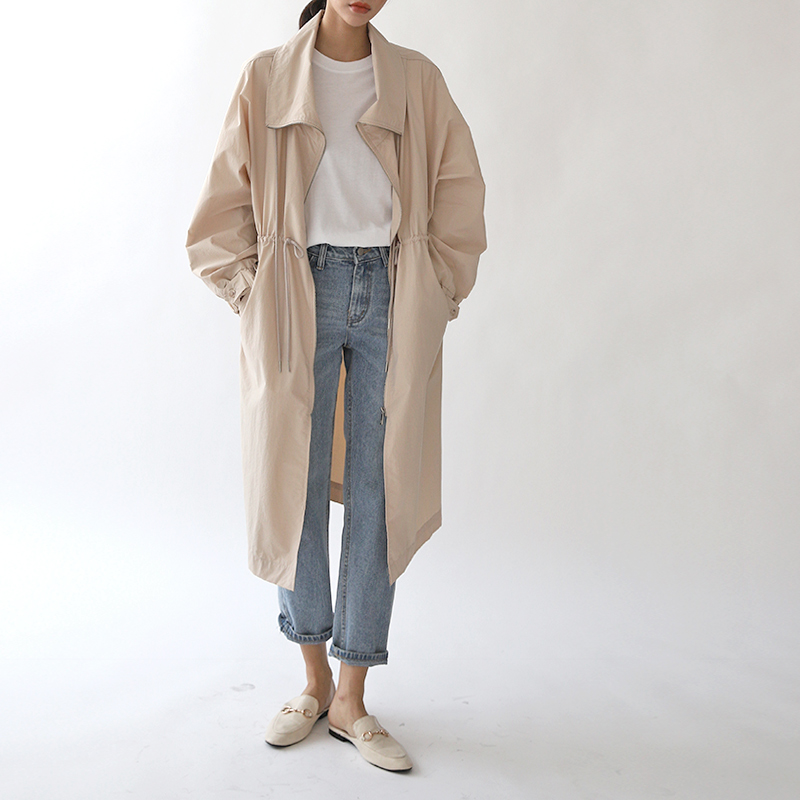

In [57]:
Image.open('/content/drive/MyDrive/kfashion/img/K-fashion(1)/1/REIGN_001_04.jpg')

In [ ]:
/content/drive/MyDrive/kfashion/img/K-fashion(1)